<a href="https://colab.research.google.com/github/MinakoNG63/DSFB/blob/main/17_Data_Imputation_on_Titanic_63070240.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 17) Data Imputation (Feature Transformation) on Titanic Dataset

Term 1 2022 - Instructor: Teerapong Leelanupab

Teaching Assistant:
1. Piyawat Chuangkrud (Sam)
2. Suvapat Manu (Mint)

***

Further Reading: [https://towardsdatascience.com/missing-data-and-imputation-89e9889268c8](https://towardsdatascience.com/missing-data-and-imputation-89e9889268c8)

In [ ]:
# This is for setting an output to show more row

# pd.set_option('display.max_colwidth', None)
# pd.set_option('max_rows', 500)
# pd.set_option('max_colwidth', 400)
# pd.describe_option('max_colwidth')

In [ ]:
#---------------------------------
#download files จาก google drive
#---------------------------------
#dataurl = 'https://drive.google.com/file/d/1t3a4iZr6f4xfPXNl1e3Kw78l3pBiEEVw/view?usp=sharing'
!gdown --id 1t3a4iZr6f4xfPXNl1e3Kw78l3pBiEEVw

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1t3a4iZr6f4xfPXNl1e3Kw78l3pBiEEVw
To: /content/Titanic_dataset.zip
100% 46.5k/46.5k [00:00<00:00, 55.7MB/s]


In [ ]:
!unzip Titanic_dataset.zip

Archive:  Titanic_dataset.zip
  inflating: titanic.csv             
   creating: pre_split/
  inflating: pre_split/test.csv      
  inflating: pre_split/train.csv     
  inflating: description.txt         


## 1. Load data
## 2. Clean data & Split data into features and a target

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_data():
  titanic_df = pd.read_csv('titanic.csv')
  return titanic_df

def clean_data(df):
  df['Cabin'] = df['Cabin'].fillna('nocabin')
  df['Age'] = df['Age'].fillna(df['Age'].mean())
  df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
  return df

def split_data_label(df):
  y = df['Survived']
  X = df.drop('Survived', axis=1)
  return X, y

## 3. Extract Feature

### 3.11 <font color='red'>Feature Extraction **function**</font>

***
We can re-start to run from here

In [ ]:
titanic_df = load_data()
clean_titanic_df = clean_data(titanic_df.copy())
X, y = split_data_label(clean_titanic_df)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize


# create a special function to extract the initial
def getinitialfeature(df):
  initial = []
  for i in range(len(df)):
    fn = df['Name'][i]
    initial.append(fn.split(',')[1].split('.')[0].strip())
  return initial

# create a special function to extract the ticket flag (Contain only number or not)
def getnumticket(ticketList):
  numticket = []
  for i in range(len(ticketList)):
    try:
      int(ticketList[i])
      numticket.append(1)
    except:
      numticket.append(0)
  return numticket

# -------------------------------------------------------------------------------------
# create a very special function to put what we do all together
# -------------------------------------------------------------------------------------
def extract_feat(df):
  X = df.copy()
  X = X.drop('PassengerId', axis=1)

  # 3.1 Cabin Zone
  X['CabinZone'] = X['Cabin'].str[0]

  # 3.2 Initial of passenger
  X['Initial'] = getinitialfeature(X)

  # 3.3 ticket flag
  ticketList = X['Ticket'].values
  X['Only_Num_in_Ticket'] = getnumticket(ticketList)

  # 3.4 Quantize Fare
  quantile_list = [0, .25, .5, .75, 1.]
  quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']
  X['Fare_Adaptive_Bin'] = pd.qcut(X['Fare'], q=quantile_list, labels=quantile_labels)

  # 3.7 Drop unwanted features
  # from 3.1 Cabin
  X.drop('Cabin', axis=1, inplace=True)
  # from 3.2 Name
  X.drop('Name', axis=1, inplace=True)
  # from 3.3 Ticket
  X.drop('Ticket', axis=1, inplace=True)

  # 3.8 Encode all categorical features
  # 3.8.1 Apply OneHotEncoding to CabinZone
  cabin_zone_features = pd.get_dummies(X['CabinZone'])
  feature_labels = ['CabinZone_' + str(cls_label) for cls_label in cabin_zone_features.columns]
  cabin_zone_features.columns = feature_labels

  # 3.8.2 Apply OneHotEncoding to Embarked
  embarked_features = pd.get_dummies(X['Embarked'])
  feature_labels = ['Embarked_' + str(cls_label) for cls_label in embarked_features.columns]
  embarked_features.columns = feature_labels

  # 3.8.3 Apply OneHotEncoding to Fare_Adaptive_Bin
  fare_adap_bin_features = pd.get_dummies(X['Fare_Adaptive_Bin'])
  feature_labels = ['FareAdapBin_' + str(cls_label) for cls_label in fare_adap_bin_features.columns]
  fare_adap_bin_features.columns = feature_labels

  # 3.8.4 Apply Dummy Coding Scheme to Sex (Male flag)
  male_features = pd.get_dummies(X['Sex'], drop_first=True)

  # 3.8.5 Apply LabelEncoding to Initial
  enc = LabelEncoder()
  initial_arr = enc.fit_transform(X['Initial'])
  initial_features = pd.DataFrame({'Initial_Feature': initial_arr})

  # 3.9 Cancatenate all features to the original dataframe
  X = pd.concat([X,cabin_zone_features,embarked_features,fare_adap_bin_features, male_features,initial_features],axis=1)

  # 3.10 Filter in only numeric features to train a model
  X = X._get_numeric_data()

  # 3.11 Apply feature normalization
  X.loc[:, X.columns] = normalize(X)
  return X

In [ ]:
X = extract_feat(X)
X

,Pclass,Age,SibSp,Parch,Fare,Only_Num_in_Ticket,CabinZone_A,CabinZone_B,CabinZone_C,CabinZone_D,...,CabinZone_n,Embarked_C,Embarked_Q,Embarked_S,FareAdapBin_0-25Q,FareAdapBin_25-50Q,FareAdapBin_50-75Q,FareAdapBin_75-100Q,male,Initial_Feature
0,0.115765,0.848945,0.038588,0.000000,0.279766,0.000000,0.0,0.00000,0.000000,0.0,...,0.038588,0.000000,0.000000,0.038588,0.038588,0.000000,0.000000,0.00000,0.038588,0.424472
1,0.012240,0.465137,0.012240,0.000000,0.872539,0.000000,0.0,0.00000,0.012240,0.0,...,0.000000,0.012240,0.000000,0.000000,0.000000,0.000000,0.000000,0.01224,0.000000,0.146885
2,0.105098,0.910849,0.000000,0.000000,0.277634,0.000000,0.0,0.00000,0.000000,0.0,...,0.035033,0.000000,0.000000,0.035033,0.000000,0.035033,0.000000,0.00000,0.000000,0.280261
3,0.015440,0.540409,0.015440,0.000000,0.819877,0.015440,0.0,0.00000,0.015440,0.0,...,0.000000,0.000000,0.000000,0.015440,0.000000,0.000000,0.000000,0.01544,0.000000,0.185283
4,0.079477,0.927237,0.000000,0.000000,0.213264,0.026492,0.0,0.00000,0.000000,0.0,...,0.026492,0.000000,0.000000,0.026492,0.000000,0.026492,0.000000,0.00000,0.026492,0.291417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.060220,0.812973,0.000000,0.000000,0.391431,0.030110,0.0,0.00000,0.000000,0.0,...,0.030110,0.000000,0.000000,0.030110,0.000000,0.030110,0.000000,0.00000,0.030110,0.421541
887,0.027420,0.520988,0.000000,0.000000,0.822613,0.027420,0.0,0.02742,0.000000,0.0,...,0.000000,0.000000,0.000000,0.027420,0.000000,0.000000,0.027420,0.00000,0.000000,0.219363
888,0.077128,0.763542,0.025709,0.051418,0.602882,0.000000,0.0,0.00000,0.000000,0.0,...,0.025709,0.000000,0.000000,0.025709,0.000000,0.000000,0.025709,0.00000,0.000000,0.205674
889,0.024232,0.630037,0.000000,0.000000,0.726966,0.024232,0.0,0.00000,0.024232,0.0,...,0.000000,0.024232,0.000000,0.000000,0.000000,0.000000,0.024232,0.00000,0.024232,0.266554


## 4. Randomly remove 5% of data

In [ ]:
def delete_5(col):
    col.loc[col.sample(frac=0.05).index] = np.nan
    return col

X_missing = X.copy()
X_missing.apply(delete_5, axis=0)
X_missing

,Pclass,Age,SibSp,Parch,Fare,Only_Num_in_Ticket,CabinZone_A,CabinZone_B,CabinZone_C,CabinZone_D,...,CabinZone_n,Embarked_C,Embarked_Q,Embarked_S,FareAdapBin_0-25Q,FareAdapBin_25-50Q,FareAdapBin_50-75Q,FareAdapBin_75-100Q,male,Initial_Feature
0,0.115765,0.848945,0.038588,0.000000,0.279766,0.000000,0.0,0.00000,0.000000,0.0,...,0.038588,0.000000,0.000000,0.038588,0.038588,0.000000,NaN,0.00000,0.038588,0.424472
1,0.012240,0.465137,0.012240,0.000000,0.872539,0.000000,0.0,0.00000,0.012240,0.0,...,0.000000,0.012240,0.000000,0.000000,0.000000,0.000000,0.000000,0.01224,0.000000,0.146885
2,0.105098,0.910849,0.000000,0.000000,0.277634,0.000000,0.0,0.00000,0.000000,0.0,...,0.035033,0.000000,0.000000,0.035033,0.000000,0.035033,0.000000,NaN,0.000000,0.280261
3,0.015440,0.540409,0.015440,0.000000,0.819877,0.015440,0.0,0.00000,0.015440,0.0,...,0.000000,0.000000,0.000000,0.015440,0.000000,0.000000,0.000000,0.01544,0.000000,0.185283
4,NaN,0.927237,NaN,0.000000,0.213264,0.026492,0.0,0.00000,0.000000,0.0,...,0.026492,0.000000,0.000000,0.026492,0.000000,0.026492,0.000000,0.00000,0.026492,0.291417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.060220,0.812973,0.000000,0.000000,0.391431,0.030110,0.0,NaN,0.000000,0.0,...,0.030110,0.000000,0.000000,NaN,0.000000,0.030110,0.000000,0.00000,0.030110,0.421541
887,0.027420,0.520988,0.000000,0.000000,0.822613,0.027420,0.0,0.02742,0.000000,0.0,...,NaN,0.000000,0.000000,0.027420,0.000000,0.000000,0.027420,0.00000,0.000000,0.219363
888,0.077128,0.763542,0.025709,0.051418,0.602882,NaN,0.0,0.00000,0.000000,0.0,...,0.025709,0.000000,0.000000,0.025709,0.000000,0.000000,0.025709,0.00000,0.000000,0.205674
889,0.024232,0.630037,0.000000,0.000000,0.726966,0.024232,0.0,0.00000,0.024232,0.0,...,0.000000,0.024232,0.000000,0.000000,0.000000,0.000000,0.024232,0.00000,0.024232,0.266554


In [ ]:
X_missing.isna().sum()

Pclass                 45
Age                    45
SibSp                  45
Parch                  45
Fare                   45
Only_Num_in_Ticket     45
CabinZone_A            45
CabinZone_B            45
CabinZone_C            45
CabinZone_D            45
CabinZone_E            45
CabinZone_F            45
CabinZone_G            45
CabinZone_T            45
CabinZone_n            45
Embarked_C             45
Embarked_Q             45
Embarked_S             45
FareAdapBin_0-25Q      45
FareAdapBin_25-50Q     45
FareAdapBin_50-75Q     45
FareAdapBin_75-100Q    45
male                   45
Initial_Feature        45
dtype: int64

In [ ]:
def eda_missing(dataframe):
  for i in range(len(dataframe.columns)):
    missing_data = dataframe[dataframe.columns[i]].isna().sum()
    perc = missing_data / len(dataframe) * 100
    print('>%d,  missing entries: %d, percentage %.2f' % (i, missing_data, perc))

In [ ]:
eda_missing(X_missing)

>0,  missing entries: 45, percentage 5.05
>1,  missing entries: 45, percentage 5.05
>2,  missing entries: 45, percentage 5.05
>3,  missing entries: 45, percentage 5.05
>4,  missing entries: 45, percentage 5.05
>5,  missing entries: 45, percentage 5.05
>6,  missing entries: 45, percentage 5.05
>7,  missing entries: 45, percentage 5.05
>8,  missing entries: 45, percentage 5.05
>9,  missing entries: 45, percentage 5.05
>10,  missing entries: 45, percentage 5.05
>11,  missing entries: 45, percentage 5.05
>12,  missing entries: 45, percentage 5.05
>13,  missing entries: 45, percentage 5.05
>14,  missing entries: 45, percentage 5.05
>15,  missing entries: 45, percentage 5.05
>16,  missing entries: 45, percentage 5.05
>17,  missing entries: 45, percentage 5.05
>18,  missing entries: 45, percentage 5.05
>19,  missing entries: 45, percentage 5.05
>20,  missing entries: 45, percentage 5.05
>21,  missing entries: 45, percentage 5.05
>22,  missing entries: 45, percentage 5.05
>23,  missing entries

4.1 Visualize Missing Data using Heatmap

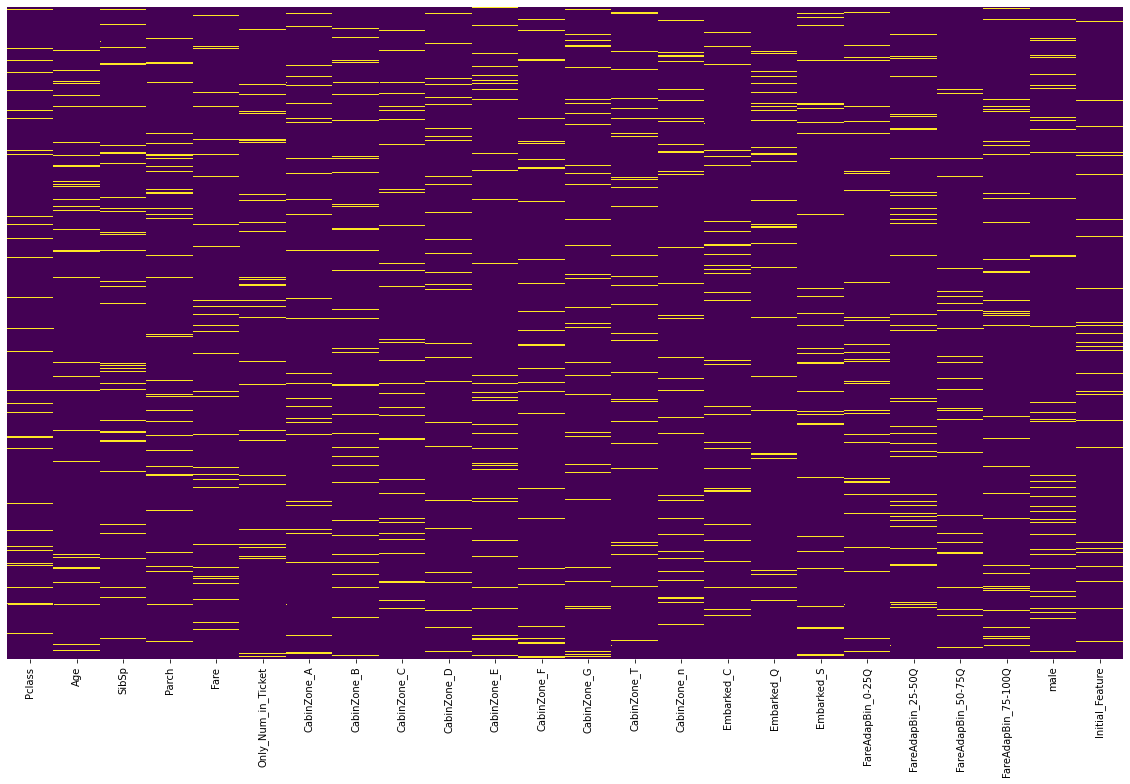

In [ ]:
import seaborn as sns
plt.figure(figsize=(20,12))
sns.heatmap(X_missing.isna(), cbar=False, cmap='viridis', yticklabels=False)

## 4.2 Another good lib for showing missing data, **missingno**

In [ ]:
!pip install missingno

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


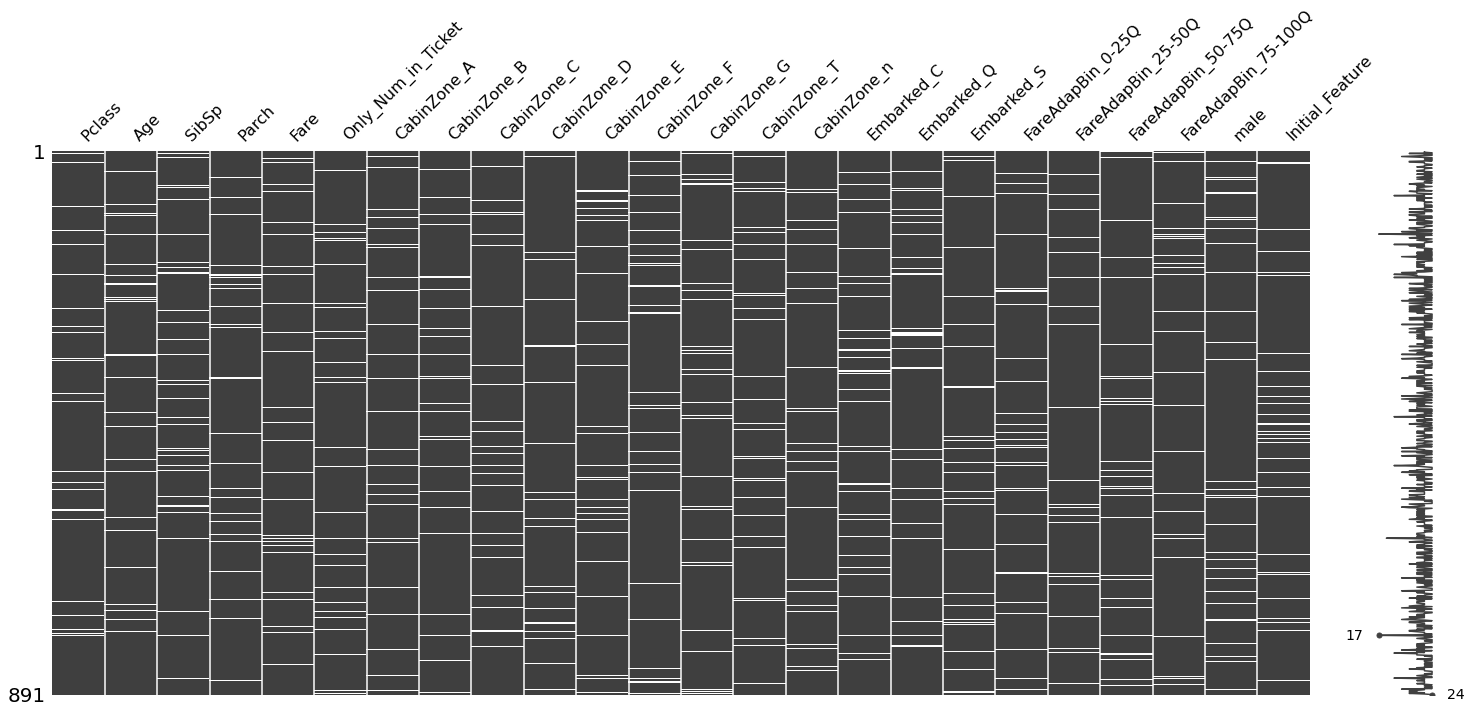

In [ ]:
import missingno as msno
msno.matrix(X_missing)

## 5. Data Imputation

## 5.1 <font color='red'>Simple Imputation</font> by 'mean', 'median', 'most_frequent' (mode), 'constant'

In [ ]:
import timeit
import math
from collections import Counter

In [ ]:
X.isnull().sum()

Pclass                 0
Age                    0
SibSp                  0
Parch                  0
Fare                   0
Only_Num_in_Ticket     0
CabinZone_A            0
CabinZone_B            0
CabinZone_C            0
CabinZone_D            0
CabinZone_E            0
CabinZone_F            0
CabinZone_G            0
CabinZone_T            0
CabinZone_n            0
Embarked_C             0
Embarked_Q             0
Embarked_S             0
FareAdapBin_0-25Q      0
FareAdapBin_25-50Q     0
FareAdapBin_50-75Q     0
FareAdapBin_75-100Q    0
male                   0
Initial_Feature        0
dtype: int64

In [ ]:
# Impute missing values by mean
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X)
X_trans = pd.DataFrame(0, index=np.arange(len(X)), columns = X.columns)
X_trans.loc[:, X.columns] = imp.transform(X)
X_trans

,Pclass,Age,SibSp,Parch,Fare,Only_Num_in_Ticket,CabinZone_A,CabinZone_B,CabinZone_C,CabinZone_D,...,CabinZone_n,Embarked_C,Embarked_Q,Embarked_S,FareAdapBin_0-25Q,FareAdapBin_25-50Q,FareAdapBin_50-75Q,FareAdapBin_75-100Q,male,Initial_Feature
0,0.115765,0.848945,0.038588,0.000000,0.279766,0.000000,0.0,0.00000,0.000000,0.0,...,0.038588,0.000000,0.000000,0.038588,0.038588,0.000000,0.000000,0.00000,0.038588,0.424472
1,0.012240,0.465137,0.012240,0.000000,0.872539,0.000000,0.0,0.00000,0.012240,0.0,...,0.000000,0.012240,0.000000,0.000000,0.000000,0.000000,0.000000,0.01224,0.000000,0.146885
2,0.105098,0.910849,0.000000,0.000000,0.277634,0.000000,0.0,0.00000,0.000000,0.0,...,0.035033,0.000000,0.000000,0.035033,0.000000,0.035033,0.000000,0.00000,0.000000,0.280261
3,0.015440,0.540409,0.015440,0.000000,0.819877,0.015440,0.0,0.00000,0.015440,0.0,...,0.000000,0.000000,0.000000,0.015440,0.000000,0.000000,0.000000,0.01544,0.000000,0.185283
4,0.079477,0.927237,0.000000,0.000000,0.213264,0.026492,0.0,0.00000,0.000000,0.0,...,0.026492,0.000000,0.000000,0.026492,0.000000,0.026492,0.000000,0.00000,0.026492,0.291417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.060220,0.812973,0.000000,0.000000,0.391431,0.030110,0.0,0.00000,0.000000,0.0,...,0.030110,0.000000,0.000000,0.030110,0.000000,0.030110,0.000000,0.00000,0.030110,0.421541
887,0.027420,0.520988,0.000000,0.000000,0.822613,0.027420,0.0,0.02742,0.000000,0.0,...,0.000000,0.000000,0.000000,0.027420,0.000000,0.000000,0.027420,0.00000,0.000000,0.219363
888,0.077128,0.763542,0.025709,0.051418,0.602882,0.000000,0.0,0.00000,0.000000,0.0,...,0.025709,0.000000,0.000000,0.025709,0.000000,0.000000,0.025709,0.00000,0.000000,0.205674
889,0.024232,0.630037,0.000000,0.000000,0.726966,0.024232,0.0,0.00000,0.024232,0.0,...,0.000000,0.024232,0.000000,0.000000,0.000000,0.000000,0.024232,0.00000,0.024232,0.266554


In [ ]:
X_trans.isna().sum()

Pclass                 0
Age                    0
SibSp                  0
Parch                  0
Fare                   0
Only_Num_in_Ticket     0
CabinZone_A            0
CabinZone_B            0
CabinZone_C            0
CabinZone_D            0
CabinZone_E            0
CabinZone_F            0
CabinZone_G            0
CabinZone_T            0
CabinZone_n            0
Embarked_C             0
Embarked_Q             0
Embarked_S             0
FareAdapBin_0-25Q      0
FareAdapBin_25-50Q     0
FareAdapBin_50-75Q     0
FareAdapBin_75-100Q    0
male                   0
Initial_Feature        0
dtype: int64

In [ ]:
tT = timeit.default_timer()  # Initialization of elapsed() function.

def elapsedStr():
    # Function that calculates elapsed time and returns it as a string. Needs init for global tT first.
    global tT
    t = abs(tT-timeit.default_timer())
    h = int(t / 3600)
    m = int((t - 3600 * h) / 60)
    s = round((t - 3600 * h) - 60 * m)
    tT = timeit.default_timer()
    if h+m+s < 0.1:
        strT = "[really quick]."
    else:
        strT = "in [{:>02d}:{:>02d}:{:>02d}].".format(h,m,s)
    return strT

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

results =[]
model = RandomForestClassifier()
strategies = ['mean', 'median', 'most_frequent','constant']

for s in strategies:
    pipeline = Pipeline([('impute', SimpleImputer(strategy=s)),('model', model)])
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X_missing, y, scoring='accuracy', cv=cv, n_jobs=-1)

    results.append(scores)
    print("Info: {0}: {1}".format(s, elapsedStr()))

for method, accuracy in zip(strategies, results):
    print('Method: {0}, mean accuracy: = {1:.3f}, max accuracy: {2:.3f}'.format(method, np.mean(accuracy), np.max(accuracy)))


Info: mean: in [00:00:08].
Info: median: in [00:00:06].
Info: most_frequent: in [00:00:06].
Info: constant: in [00:00:07].
Method: mean, mean accuracy: = 0.795, max accuracy: 0.899
Method: median, mean accuracy: = 0.791, max accuracy: 0.865
Method: most_frequent, mean accuracy: = 0.784, max accuracy: 0.867
Method: constant, mean accuracy: = 0.784, max accuracy: 0.910


In [ ]:
results

[array([0.73333333, 0.7752809 , 0.7752809 , 0.8988764 , 0.76404494,
        0.75280899, 0.78651685, 0.80898876, 0.84269663, 0.83146067,
        0.83333333, 0.82022472, 0.70786517, 0.83146067, 0.75280899,
        0.76404494, 0.83146067, 0.79775281, 0.79775281, 0.82022472,
        0.75555556, 0.76404494, 0.79775281, 0.78651685, 0.7752809 ,
        0.84269663, 0.74157303, 0.82022472, 0.86516854, 0.76404494]),
 array([0.72222222, 0.78651685, 0.79775281, 0.85393258, 0.78651685,
        0.78651685, 0.78651685, 0.78651685, 0.83146067, 0.82022472,
        0.82222222, 0.79775281, 0.70786517, 0.84269663, 0.76404494,
        0.75280899, 0.79775281, 0.80898876, 0.79775281, 0.80898876,
        0.76666667, 0.74157303, 0.82022472, 0.78651685, 0.7752809 ,
        0.82022472, 0.73033708, 0.83146067, 0.86516854, 0.74157303]),
 array([0.68888889, 0.80898876, 0.76404494, 0.86516854, 0.73033708,
        0.7752809 , 0.82022472, 0.78651685, 0.79775281, 0.7752809 ,
        0.86666667, 0.78651685, 0.76404494, 

## 5.2 IterativeImputer ใช้ Regressor model ในการทำนาย value ที่หายไป
[Scikit Learn IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html)

### 5.2.1 BayesianRidge
default=[Bayesian ridge regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html)



In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=500, random_state=0)
X_filled = imp.fit_transform(X_missing)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_filled, y, scoring='accuracy', cv=cv, n_jobs=-1)
print("Info: IterativeImputer: ", elapsedStr())

# strategies.append('IterativeImputer-BayesianRidge')
# results.append(scores)

Info: IterativeImputer:  in [00:43:37].


### 5.2.2 Try to change Estimator to SGDRegressor

In [ ]:
from sklearn.linear_model import SGDRegressor

imp = IterativeImputer(estimator=SGDRegressor(), max_iter=500, random_state=0)
X_filled = imp.fit_transform(X_missing)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_filled, y, scoring='accuracy', cv=cv, n_jobs=-1)
print("Info: IterativeImputer: ", elapsedStr())

# strategies.append('IterativeImputer-SGDRegressor')
# results.append(scores)

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


Info: IterativeImputer:  in [00:00:31].


# 5.2.3 <font color='red'>Perform a small heuristic expriment comparing different regresssors for data imputation</font>

In [ ]:
from sklearn.linear_model import BayesianRidge, SGDRegressor, ElasticNet, Lasso

model = RandomForestClassifier()
estimators = {'BayesianRidge':BayesianRidge(), 'SGDRegressor':SGDRegressor(), 'ElasticNet':ElasticNet(random_state=0), 'Lasso':Lasso()}

for key, est in estimators.items():
    pipeline = Pipeline([('impute', IterativeImputer(estimator=est, max_iter=1000, random_state=0)),('model', model)])
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X_missing, y, scoring='accuracy', cv=cv, n_jobs=-1)

    strategies.append('IterativeImputer-' + key)
    results.append(scores)
    print("Info: {0}: {1}".format(s, elapsedStr()))

for method, accuracy in zip(strategies, results):
    print('Method: {0}, mean accuracy: = {1:.3f}, max accuracy: {2:.3f}'.format(method, np.mean(accuracy), np.max(accuracy)))

Info: constant: in [00:00:46].
Info: constant: in [00:21:07].
Info: constant: in [00:00:07].
Info: constant: in [00:00:07].
Method: mean, mean accuracy: = 0.795, max accuracy: 0.899
Method: median, mean accuracy: = 0.791, max accuracy: 0.865
Method: most_frequent, mean accuracy: = 0.784, max accuracy: 0.867
Method: constant, mean accuracy: = 0.784, max accuracy: 0.910
Method: IterativeImputer-BayesianRidge, mean accuracy: = 0.791, max accuracy: 0.865
Method: IterativeImputer-SGDRegressor, mean accuracy: = 0.795, max accuracy: 0.888
Method: IterativeImputer-ElasticNet, mean accuracy: = 0.797, max accuracy: 0.888
Method: IterativeImputer-Lasso, mean accuracy: = 0.798, max accuracy: 0.910


## 5.3 KNNImputer
From my understanding, this approach is similar to Hot-deck and Cold-deck imputation

In [ ]:
from sklearn.impute import KNNImputer

imp = KNNImputer(n_neighbors=2, weights="uniform")
X_filled = imp.fit_transform(X_missing)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_filled, y, scoring='accuracy', cv=cv, n_jobs=-1)
print("Info: KNNImputer: ", elapsedStr())

strategies.append('KNNImputer')
results.append(scores)

nested_list = []
for method, accuracy in zip(strategies, results):
  avg_acc = np.mean(accuracy)
  inner_list = [method,avg_acc]
  nested_list.append(inner_list)
  print('Method: {0}, mean accuracy: = {1:.3f}, max accuracy: {2:.3f}'.format(method, avg_acc, np.max(accuracy)))
avg_acc_df = pd.DataFrame(nested_list,columns=['method','avg_acc'])
avg_acc_df.set_index('method')

Info: KNNImputer:  in [00:00:06].
Method: mean, mean accuracy: = 0.792, max accuracy: 0.899
Method: median, mean accuracy: = 0.796, max accuracy: 0.888
Method: most_frequent, mean accuracy: = 0.790, max accuracy: 0.865
Method: constant, mean accuracy: = 0.793, max accuracy: 0.854
Method: IterativeImputer-BayesianRidge, mean accuracy: = 0.798, max accuracy: 0.888
Method: IterativeImputer-SGDRegressor, mean accuracy: = 0.787, max accuracy: 0.888
Method: IterativeImputer-ElasticNet, mean accuracy: = 0.793, max accuracy: 0.910
Method: IterativeImputer-Lasso, mean accuracy: = 0.797, max accuracy: 0.899
Method: KNNImputer, mean accuracy: = 0.791, max accuracy: 0.876


,avg_acc
method,
mean,0.792364
median,0.795734
most_frequent,0.789746
constant,0.793113
IterativeImputer-BayesianRidge,0.797965
IterativeImputer-SGDRegressor,0.786737
IterativeImputer-ElasticNet,0.793487
IterativeImputer-Lasso,0.797233
KNNImputer,0.790874


In [ ]:
nested_list = []
for method, accuracy in zip(strategies, results):
  avg_acc = np.mean(accuracy)
  inner_list = [method,avg_acc]
  nested_list.append(inner_list)
  print('Method: {0}, mean accuracy: = {1:.3f}, max accuracy: {2:.3f}'.format(method, avg_acc, np.max(accuracy)))
avg_acc_df = pd.DataFrame(nested_list,columns=['method','avg_acc'])
avg_acc_df.set_index('method')
avg_acc_df

Method: mean, mean accuracy: = 0.792, max accuracy: 0.899
Method: median, mean accuracy: = 0.796, max accuracy: 0.888
Method: most_frequent, mean accuracy: = 0.790, max accuracy: 0.865
Method: constant, mean accuracy: = 0.793, max accuracy: 0.854
Method: IterativeImputer-BayesianRidge, mean accuracy: = 0.798, max accuracy: 0.888
Method: IterativeImputer-SGDRegressor, mean accuracy: = 0.787, max accuracy: 0.888
Method: IterativeImputer-ElasticNet, mean accuracy: = 0.793, max accuracy: 0.910
Method: IterativeImputer-Lasso, mean accuracy: = 0.797, max accuracy: 0.899
Method: KNNImputer, mean accuracy: = 0.791, max accuracy: 0.876


,method,avg_acc
0,mean,0.792364
1,median,0.795734
2,most_frequent,0.789746
3,constant,0.793113
4,IterativeImputer-BayesianRidge,0.797965
5,IterativeImputer-SGDRegressor,0.786737
6,IterativeImputer-ElasticNet,0.793487
7,IterativeImputer-Lasso,0.797233
8,KNNImputer,0.790874


In [ ]:
avg_acc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   method   9 non-null      object 
 1   avg_acc  9 non-null      float64
dtypes: float64(1), object(1)
memory usage: 272.0+ bytes


In [ ]:
# Max accuracy imputation method
avg_acc_df.iloc[avg_acc_df['avg_acc'].argmax()]

method     IterativeImputer-BayesianRidge
avg_acc                          0.797965
Name: 4, dtype: object

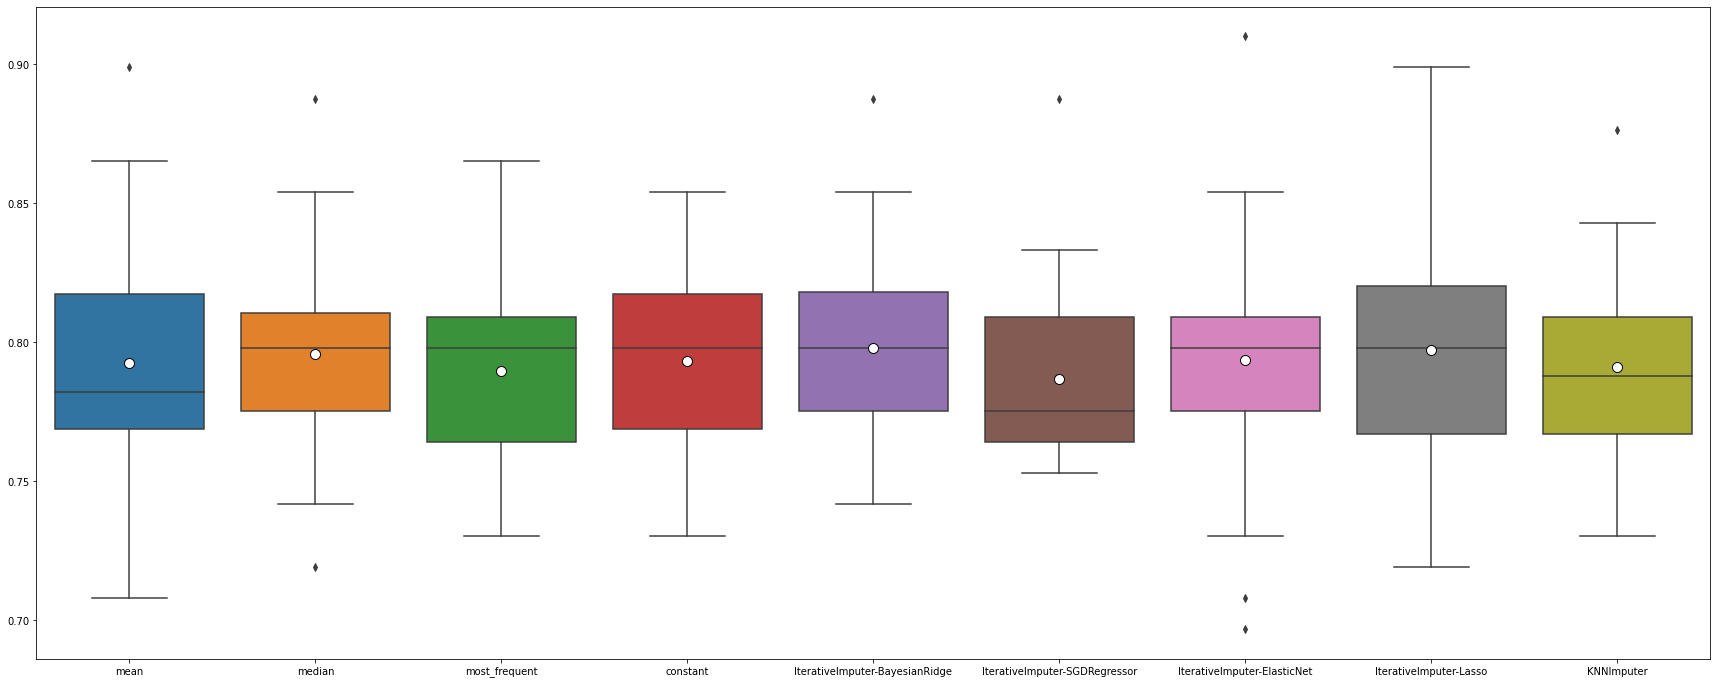

In [ ]:
plt.figure(figsize=(30,12))
result_df = pd.DataFrame(np.transpose(results), columns=strategies)
sns.boxplot(data=result_df,
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white",
                       "markeredgecolor":"black",
                      "markersize":"10"})